# Import the essential libraries

In [1]:
# Required imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import random
import cv2
import scipy.io
import numpy as np
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import urllib.request
import tarfile

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


# Downloading the BSDS500 dataset 

In [2]:
def download_and_extract_dataset():
    dataset_url = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
    tgz_file = "BSR_bsds500.tgz"
    
    if not os.path.exists('BSR'):
        print("Downloading BSDS500 dataset...")
        
        # Create a custom progress bar for download
        class DownloadProgressBar(tqdm):
            def update_to(self, b=1, bsize=1, tsize=None):
                if tsize is not None:
                    self.total = tsize
                self.update(b * bsize - self.n)
        
        with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc="Downloading") as t:
            urllib.request.urlretrieve(dataset_url, tgz_file, reporthook=t.update_to)
        
        print("Extracting dataset...")
        with tarfile.open(tgz_file, 'r:gz') as tar:
            for member in tqdm(iterable=tar.getmembers(), total=len(tar.getmembers()), desc="Extracting"):
                tar.extract(member)
        print("Dataset extracted successfully!")

# Defining BSDS500Dataset class

In [3]:
class BSDS500Dataset(Dataset):
    def __init__(self, image_folder, gt_folder, transform=None, mode="annotator1"):
        """
        Args:
            image_folder: Path to image directory.
            gt_folder: Path to ground truth directory.
            transform: Data augmentation and preprocessing.
            mode: "annotator1" for using Annotator 1's labels, "consensus" for modified ground truth.
        """
        self.image_folder = image_folder
        self.gt_folder = gt_folder
        self.filenames = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
        self.transform = transform
        self.mode = mode  # Choose annotation mode

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        img_path = os.path.join(self.image_folder, filename)
        mat_path = os.path.join(self.gt_folder, os.path.splitext(filename)[0] + '.mat')

        # Load image in RGB format
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image = Image.fromarray(image)  # Convert to PIL image

        # Apply data augmentation (if specified)
        if self.transform:
            image = self.transform(image)

        # Load ground truth
        gt_data = scipy.io.loadmat(mat_path)
        gt_list = gt_data['groundTruth'][0]  # List of multiple segmentations

        if self.mode == "annotator1":
            # Use only Annotator 1's labels (first in the list)
            gt = np.array(gt_list[0]['Boundaries'][0, 0], dtype=np.float32)
        elif self.mode == "consensus":
            # Stack all boundary masks (each mask has shape H x W)
            gt_stack = np.stack([np.array(gt_struct['Boundaries'][0, 0], dtype=np.float32) for gt_struct in gt_list], axis=0)
            # Apply threshold: A pixel is an edge if at least 3 annotators marked it as an edge
            gt = (gt_stack.sum(axis=0) >= 3).astype(np.float32)
        else:
            raise ValueError("Invalid mode. Choose 'annotator1' or 'consensus'.")

        # Resize ground truth & ensure binary mask
        gt = cv2.resize(gt, (256, 256), interpolation=cv2.INTER_NEAREST)  # Maintain hard edges
        gt = torch.from_numpy(gt).float().unsqueeze(0)  # Convert to tensor (1, H, W)
        gt = torch.clamp(gt, min=0, max=1)
        return image, gt

# Defining HED Class as required using vgg16

In [4]:
class HED(nn.Module):
    def __init__(self):
        super(HED, self).__init__()
        # Load pretrained VGG16 without fully connected layers
        vgg16 = models.vgg16(pretrained=True)
        
        # Extract features before each pooling layer (excluding the final pooling)
        # VGG16 structure: 2 conv -> pool -> 2 conv -> pool -> 3 conv -> pool -> 3 conv -> pool -> 3 conv -> pool
        features = list(vgg16.features.children())
        
        # Create feature extractors for each stage
        self.stage1 = nn.Sequential(*features[:4])   # Before first pooling
        self.stage2 = nn.Sequential(*features[4:9])  # Before second pooling
        self.stage3 = nn.Sequential(*features[9:16]) # Before third pooling
        self.stage4 = nn.Sequential(*features[16:23]) # Before fourth pooling
        self.stage5 = nn.Sequential(*features[23:30]) # Before fifth pooling (exclude final pooling)
        
        # Side output layers (1x1 convolutions)
        self.side1 = nn.Conv2d(64, 1, kernel_size=1)
        self.side2 = nn.Conv2d(128, 1, kernel_size=1)
        self.side3 = nn.Conv2d(256, 1, kernel_size=1)
        self.side4 = nn.Conv2d(512, 1, kernel_size=1)
        self.side5 = nn.Conv2d(512, 1, kernel_size=1)
        
        # Fusion layer (learnable weights)
        self.fuse = nn.Conv2d(5, 1, kernel_size=1)
        
        # Initialize weights for side outputs and fusion
        self._initialize_weights()

    def _initialize_weights(self):
        for m in [self.side1, self.side2, self.side3, self.side4, self.side5, self.fuse]:
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Store original input size for upsampling
        input_size = x.size()[2:]
        
        # Forward pass through VGG stages
        stage1 = self.stage1(x)
        stage2 = self.stage2(stage1)
        stage3 = self.stage3(stage2)
        stage4 = self.stage4(stage3)
        stage5 = self.stage5(stage4)
        
        # Side outputs with upsampling to original size
        side1 = self.side1(stage1)
        side1 = F.interpolate(side1, size=input_size, mode='bilinear', align_corners=True)
        
        side2 = self.side2(stage2)
        side2 = F.interpolate(side2, size=input_size, mode='bilinear', align_corners=True)
        
        side3 = self.side3(stage3)
        side3 = F.interpolate(side3, size=input_size, mode='bilinear', align_corners=True)
        
        side4 = self.side4(stage4)
        side4 = F.interpolate(side4, size=input_size, mode='bilinear', align_corners=True)

        side5 = self.side5(stage5)
        side5 = F.interpolate(side5, size=input_size, mode='bilinear', align_corners=True)
        
        # Concatenate side outputs and apply fusion layer
        fused = torch.cat([side1, side2, side3, side4, side5], dim=1)
        fused = self.fuse(fused)
        
        # Return all outputs (side outputs and fused output)
        return [side1, side2, side3, side4, side5, fused]
    

# Implementing Class Balanced Loss from HED Paper

In [5]:
# Class Balanced Loss (from HED Paper) 
class ClassBalancedLoss(nn.Module):
    def __init__(self):
        super(ClassBalancedLoss, self).__init__()

    def forward(self, pred, target):
        """
        Class-balanced cross-entropy loss as defined in the HED paper.
        :param pred: Predicted edge map (B, 1, H, W)
        :param target: Ground truth binary edge map (B, 1, H, W)
        :return: Scalar loss value
        """
        pred = torch.sigmoid(pred)
        pred = torch.clamp(pred, 1e-6, 1 - 1e-6)  # Clip to avoid log(0)

        # Flatten tensors to (B, H*W)
        # Fix: The view operation had incorrect parameters
        pred = pred.view(pred.shape[0], -1)  # (B, H*W)
        target = target.view(target.shape[0], -1)  # (B, H*W)

        # Compute class balancing weights
        num_pos = torch.sum(target, dim=1, keepdim=True)  # (B, 1) - sum over pixels
        num_neg = torch.sum(1 - target, dim=1, keepdim=True)  # (B, 1)
        num_total = num_pos + num_neg  # (B, 1)

        # Avoid division by zero
        beta = num_neg / (num_total + 1e-6)  # (B, 1)
        inv_beta = num_pos / (num_total + 1e-6)  # (B, 1)

        # Expand to match (B, H*W)
        beta = beta.expand_as(target)
        inv_beta = inv_beta.expand_as(target)

        # Compute weighted loss
        loss = -beta * target * torch.log(pred) - inv_beta * (1 - target) * torch.log(1 - pred)

        return loss.mean()


# Coding the HED Loss calculation

In [6]:
# HED Loss with Side Outputs
class HEDLoss(nn.Module):
    def __init__(self):
        super(HEDLoss, self).__init__()
        self.bce = ClassBalancedLoss()  # Class balanced BCE

    def forward(self, outputs, target):
        side_outputs, fused_output = outputs[:-1], outputs[-1]
        side_loss = sum(self.bce(side, target) for side in side_outputs)  # Sum side losses
        fused_loss = self.bce(fused_output, target)  # Final fused loss
        return side_loss + fused_loss  # Total loss

# Training of the model

In [7]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device, save_path):
    """
    Train the HED model and validate it on the dataset.
    """
    best_val_loss = float('inf')
    train_losses, val_losses = [], []

    scaler = torch.amp.GradScaler('cuda', enabled=torch.cuda.is_available()) 
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        # Add tqdm progress bar for training
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}") as pbar:
            for images, targets in pbar:
                images, targets = images.to(device), targets.to(device)
                
                optimizer.zero_grad()
                # Fix the deprecated autocast API
                with torch.amp.autocast('cuda', enabled=False):
                    outputs = model(images)
                    loss = criterion(outputs, targets)
                
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                
                train_loss += loss.item()
                pbar.set_postfix({"loss": loss.item()})
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, targets in tqdm(val_loader, desc="Validation"):
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Update Learning Rate
        scheduler.step()
        
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save Best Model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_loss': best_val_loss
            }, save_path)
            print(f" Saved new best model at epoch {epoch+1}")
    
    return train_losses, val_losses

# Visualization on edge predictions made by HED with respect to ground truth and actual image

In [8]:
def visualize_predictions(model, test_loader, device, num_images=6):
    """
    Visualize predictions of the HED model.
    """
    model.eval()
    fig, axes = plt.subplots(num_images, 4, figsize=(16, num_images * 4))
    
    # Get fusion weights
    fusion_weights = model.fuse.weight.data.cpu().numpy()
    print("Fusion weights:", fusion_weights.reshape(-1))
    
    with torch.no_grad():
        for i, (image, target) in enumerate(test_loader):
            if i >= num_images:
                break
            
            image = image.to(device)
            outputs = model(image)
            
            # Get all side outputs and fused output
            side_outputs = outputs[:-1]
            fused_output = outputs[-1]
            
            # Apply sigmoid to get probability maps
            side_probs = [torch.sigmoid(out).squeeze().cpu().numpy() for out in side_outputs]
            fused_prob = torch.sigmoid(fused_output).squeeze().cpu().numpy()

            # Threshold fused output to get binary edge map
            fused_binary = (fused_prob > 0.5).astype(float)
            
            # Convert image and target to numpy for visualization
            image_np = image.squeeze().cpu().permute(1, 2, 0).numpy()
            # Denormalize image
            image_np = (image_np * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
            image_np = np.clip(image_np, 0, 1)
            
            target_np = target.squeeze().cpu().numpy()
            
            # Plot original, ground truth, and predicted edges
            axes[i, 0].imshow(image_np)
            axes[i, 0].set_title("Original Image")
            axes[i, 1].imshow(target_np, cmap='gray')
            axes[i, 1].set_title("Ground Truth")
            axes[i, 2].imshow(fused_prob, cmap='gray')
            axes[i, 2].set_title("Predicted Output")
            axes[i, 3].imshow(fused_binary, cmap='gray')
            axes[i, 3].set_title("Thresholded Edges")
            
            for ax in axes[i]:
                ax.axis("off")
        
        plt.tight_layout()
        plt.show()

In [9]:
def visualize_sideoutput_predictions(model, test_loader, device, num_images=3):
    """Visualize predictions and side outputs with fusion weights"""
    model.eval()
    fig, axes = plt.subplots(num_images*2, 5, figsize=(25, 4*2*num_images))
    
    # Get fusion weights and convert to numpy array
    fusion_weights = model.fuse.weight.data.cpu().numpy().reshape(-1)
    
    with torch.no_grad():
        for i, (image, target) in enumerate(test_loader):
            if i >= num_images:
                break
                
            image = image.to(device)
            outputs = model(image)
            
            # Get all side outputs and fused output
            side_outputs = outputs[:-1]
            fused_output = outputs[-1]
            
            # Apply sigmoid to get probability maps
            side_probs = [torch.sigmoid(out).squeeze().cpu().numpy() for out in side_outputs]
            fused_prob = torch.sigmoid(fused_output).squeeze().cpu().numpy()
            
            # Convert image and target to numpy for visualization
            image_np = image.squeeze().cpu().permute(1, 2, 0).numpy()
            image_np = (image_np * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
            image_np = np.clip(image_np, 0, 1)
            target_np = target.squeeze().cpu().numpy()
            
            # Plot main results in first row
            axes[2*i,0].imshow(image_np)
            axes[2*i,0].set_title('Original Image')
            axes[2*i,0].axis('off')
            
            axes[2*i,1].imshow(target_np, cmap='gray')
            axes[2*i,1].set_title('Ground Truth')
            axes[2*i,1].axis('off')
            
            axes[2*i,2].imshow(fused_prob, cmap='gray')
            axes[2*i,2].set_title('Fused Output')
            axes[2*i,2].axis('off')
            
            axes[2*i,3].imshow((fused_prob > 0.5).astype(float), cmap='gray')
            axes[2*i,3].set_title('Thresholded Output')
            axes[2*i,3].axis('off')
            
            # Hide unused subplot in first row
            axes[2*i,4].axis('off')
            
            # Plot side outputs in second row
            for j in range(5):
                axes[2*i+1,j].imshow(side_probs[j], cmap='gray')
                axes[2*i+1,j].set_title(f'Side{j+1} (w={fusion_weights[j]:.2f})')
                axes[2*i+1,j].axis('off')

    plt.tight_layout()
    plt.show()


# Main function to combine all the above defined functions into a single pipeline

Downloading: 70.8MB [00:01, 42.0MB/s]                            


Extracting dataset...


Extracting: 100%|██████████| 1125/1125 [00:00<00:00, 1707.88it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Dataset extracted successfully!
Using device: cuda


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 197MB/s] 


Training HED model for 50 epochs...


Validation: 100%|██████████| 100/100 [00:00<00:00, 106.69it/s]


Epoch [1/50], Train Loss: 0.2044, Val Loss: 0.1935
 Saved new best model at epoch 1


Validation: 100%|██████████| 100/100 [00:01<00:00, 94.12it/s]


Epoch [2/50], Train Loss: 0.1829, Val Loss: 0.1772
 Saved new best model at epoch 2


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.96it/s]


Epoch [3/50], Train Loss: 0.1705, Val Loss: 0.1663
 Saved new best model at epoch 3


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.64it/s]


Epoch [4/50], Train Loss: 0.1612, Val Loss: 0.1586
 Saved new best model at epoch 4


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.38it/s]


Epoch [5/50], Train Loss: 0.1554, Val Loss: 0.1530
 Saved new best model at epoch 5


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.89it/s]


Epoch [6/50], Train Loss: 0.1507, Val Loss: 0.1488
 Saved new best model at epoch 6


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.78it/s]


Epoch [7/50], Train Loss: 0.1476, Val Loss: 0.1456
 Saved new best model at epoch 7


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.59it/s]


Epoch [8/50], Train Loss: 0.1448, Val Loss: 0.1431
 Saved new best model at epoch 8


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.62it/s]


Epoch [9/50], Train Loss: 0.1427, Val Loss: 0.1411
 Saved new best model at epoch 9


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.60it/s]


Epoch [10/50], Train Loss: 0.1412, Val Loss: 0.1396
 Saved new best model at epoch 10


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.45it/s]


Epoch [11/50], Train Loss: 0.1399, Val Loss: 0.1390
 Saved new best model at epoch 11


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.05it/s]


Epoch [12/50], Train Loss: 0.1397, Val Loss: 0.1384
 Saved new best model at epoch 12


Validation: 100%|██████████| 100/100 [00:00<00:00, 112.00it/s]


Epoch [13/50], Train Loss: 0.1392, Val Loss: 0.1379
 Saved new best model at epoch 13


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.67it/s]


Epoch [14/50], Train Loss: 0.1386, Val Loss: 0.1375
 Saved new best model at epoch 14


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.81it/s]


Epoch [15/50], Train Loss: 0.1382, Val Loss: 0.1371
 Saved new best model at epoch 15


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.88it/s]


Epoch [16/50], Train Loss: 0.1379, Val Loss: 0.1367
 Saved new best model at epoch 16


Validation: 100%|██████████| 100/100 [00:01<00:00, 94.35it/s]


Epoch [17/50], Train Loss: 0.1376, Val Loss: 0.1364
 Saved new best model at epoch 17


Validation: 100%|██████████| 100/100 [00:00<00:00, 105.13it/s]


Epoch [18/50], Train Loss: 0.1374, Val Loss: 0.1361
 Saved new best model at epoch 18


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.87it/s]


Epoch [19/50], Train Loss: 0.1371, Val Loss: 0.1358
 Saved new best model at epoch 19


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.74it/s]


Epoch [20/50], Train Loss: 0.1369, Val Loss: 0.1356
 Saved new best model at epoch 20


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.61it/s]


Epoch [21/50], Train Loss: 0.1366, Val Loss: 0.1355
 Saved new best model at epoch 21


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.57it/s]


Epoch [22/50], Train Loss: 0.1366, Val Loss: 0.1353
 Saved new best model at epoch 22


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.44it/s]


Epoch [23/50], Train Loss: 0.1365, Val Loss: 0.1352
 Saved new best model at epoch 23


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.51it/s]


Epoch [24/50], Train Loss: 0.1363, Val Loss: 0.1351
 Saved new best model at epoch 24


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.76it/s]


Epoch [25/50], Train Loss: 0.1363, Val Loss: 0.1350
 Saved new best model at epoch 25


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.80it/s]


Epoch [26/50], Train Loss: 0.1362, Val Loss: 0.1349
 Saved new best model at epoch 26


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.30it/s]


Epoch [27/50], Train Loss: 0.1361, Val Loss: 0.1348
 Saved new best model at epoch 27


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.82it/s]


Epoch [28/50], Train Loss: 0.1360, Val Loss: 0.1347
 Saved new best model at epoch 28


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.50it/s]


Epoch [29/50], Train Loss: 0.1359, Val Loss: 0.1346
 Saved new best model at epoch 29


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.07it/s]


Epoch [30/50], Train Loss: 0.1359, Val Loss: 0.1345
 Saved new best model at epoch 30


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.47it/s]


Epoch [31/50], Train Loss: 0.1358, Val Loss: 0.1345
 Saved new best model at epoch 31


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.71it/s]


Epoch [32/50], Train Loss: 0.1358, Val Loss: 0.1344
 Saved new best model at epoch 32


Validation: 100%|██████████| 100/100 [00:00<00:00, 108.98it/s]


Epoch [33/50], Train Loss: 0.1357, Val Loss: 0.1344
 Saved new best model at epoch 33


Validation: 100%|██████████| 100/100 [00:00<00:00, 104.66it/s]


Epoch [34/50], Train Loss: 0.1357, Val Loss: 0.1344
 Saved new best model at epoch 34


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.95it/s]


Epoch [35/50], Train Loss: 0.1357, Val Loss: 0.1343
 Saved new best model at epoch 35


Validation: 100%|██████████| 100/100 [00:00<00:00, 107.37it/s]


Epoch [36/50], Train Loss: 0.1357, Val Loss: 0.1343
 Saved new best model at epoch 36


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.96it/s]


Epoch [37/50], Train Loss: 0.1356, Val Loss: 0.1342
 Saved new best model at epoch 37


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.50it/s]


Epoch [38/50], Train Loss: 0.1356, Val Loss: 0.1342
 Saved new best model at epoch 38


Validation: 100%|██████████| 100/100 [00:01<00:00, 97.68it/s]


Epoch [39/50], Train Loss: 0.1355, Val Loss: 0.1342
 Saved new best model at epoch 39


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.14it/s]


Epoch [40/50], Train Loss: 0.1356, Val Loss: 0.1341
 Saved new best model at epoch 40


Validation: 100%|██████████| 100/100 [00:00<00:00, 104.21it/s]


Epoch [41/50], Train Loss: 0.1355, Val Loss: 0.1341
 Saved new best model at epoch 41


Validation: 100%|██████████| 100/100 [00:00<00:00, 110.72it/s]


Epoch [42/50], Train Loss: 0.1355, Val Loss: 0.1341
 Saved new best model at epoch 42


Validation: 100%|██████████| 100/100 [00:00<00:00, 107.38it/s]


Epoch [43/50], Train Loss: 0.1355, Val Loss: 0.1341
 Saved new best model at epoch 43


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.94it/s]


Epoch [44/50], Train Loss: 0.1355, Val Loss: 0.1341
 Saved new best model at epoch 44


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.66it/s]


Epoch [45/50], Train Loss: 0.1355, Val Loss: 0.1340
 Saved new best model at epoch 45


Validation: 100%|██████████| 100/100 [00:00<00:00, 111.97it/s]


Epoch [46/50], Train Loss: 0.1355, Val Loss: 0.1340
 Saved new best model at epoch 46


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.92it/s]


Epoch [47/50], Train Loss: 0.1354, Val Loss: 0.1340
 Saved new best model at epoch 47


Validation: 100%|██████████| 100/100 [00:00<00:00, 112.06it/s]


Epoch [48/50], Train Loss: 0.1354, Val Loss: 0.1340
 Saved new best model at epoch 48


Validation: 100%|██████████| 100/100 [00:00<00:00, 109.55it/s]


Epoch [49/50], Train Loss: 0.1353, Val Loss: 0.1340
 Saved new best model at epoch 49


Validation: 100%|██████████| 100/100 [00:00<00:00, 103.10it/s]


Epoch [50/50], Train Loss: 0.1354, Val Loss: 0.1340
 Saved new best model at epoch 50


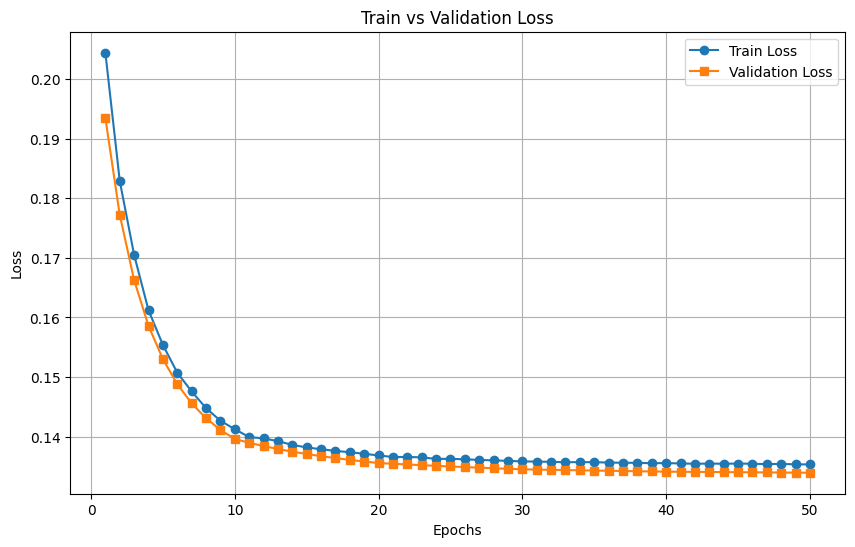

<ipython-input-10-0f3adf3662da>:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_hed_model.pth")


Visualizing predictions on test set...
Fusion weights: [-0.05706654 -0.65359616  0.27521542  0.42620718 -0.7748762 ]


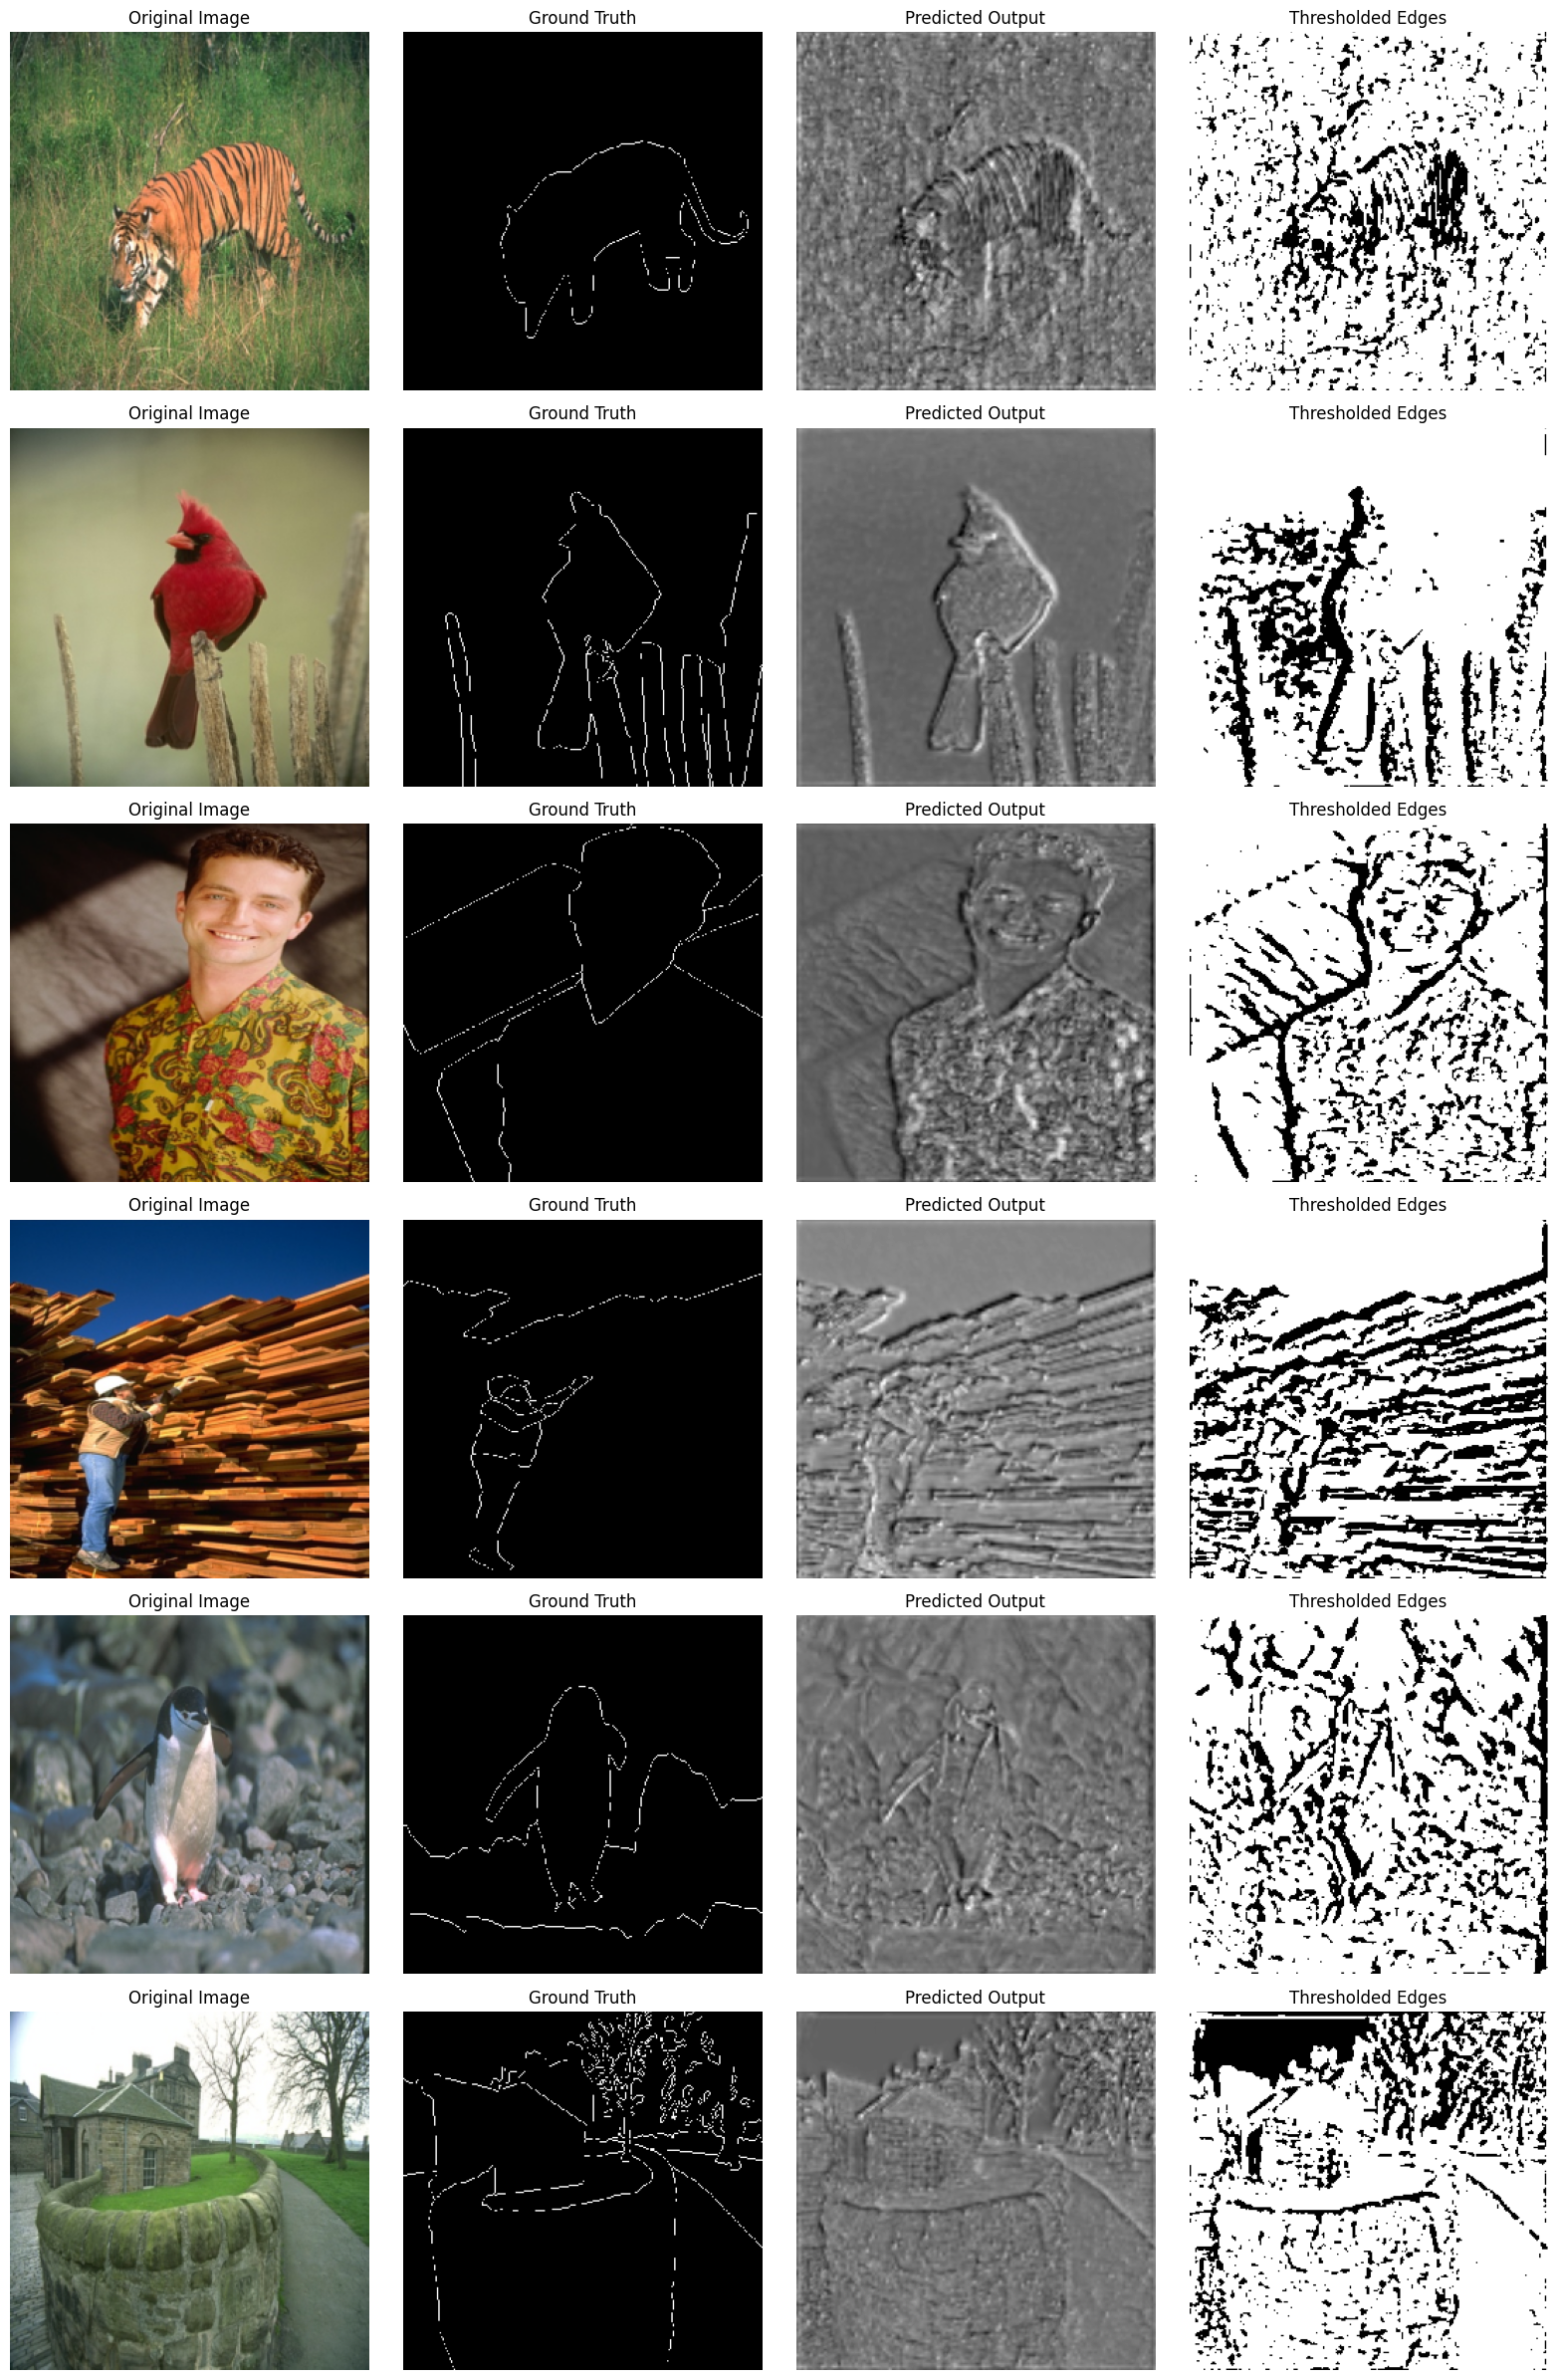

Visualizing side outpusts...


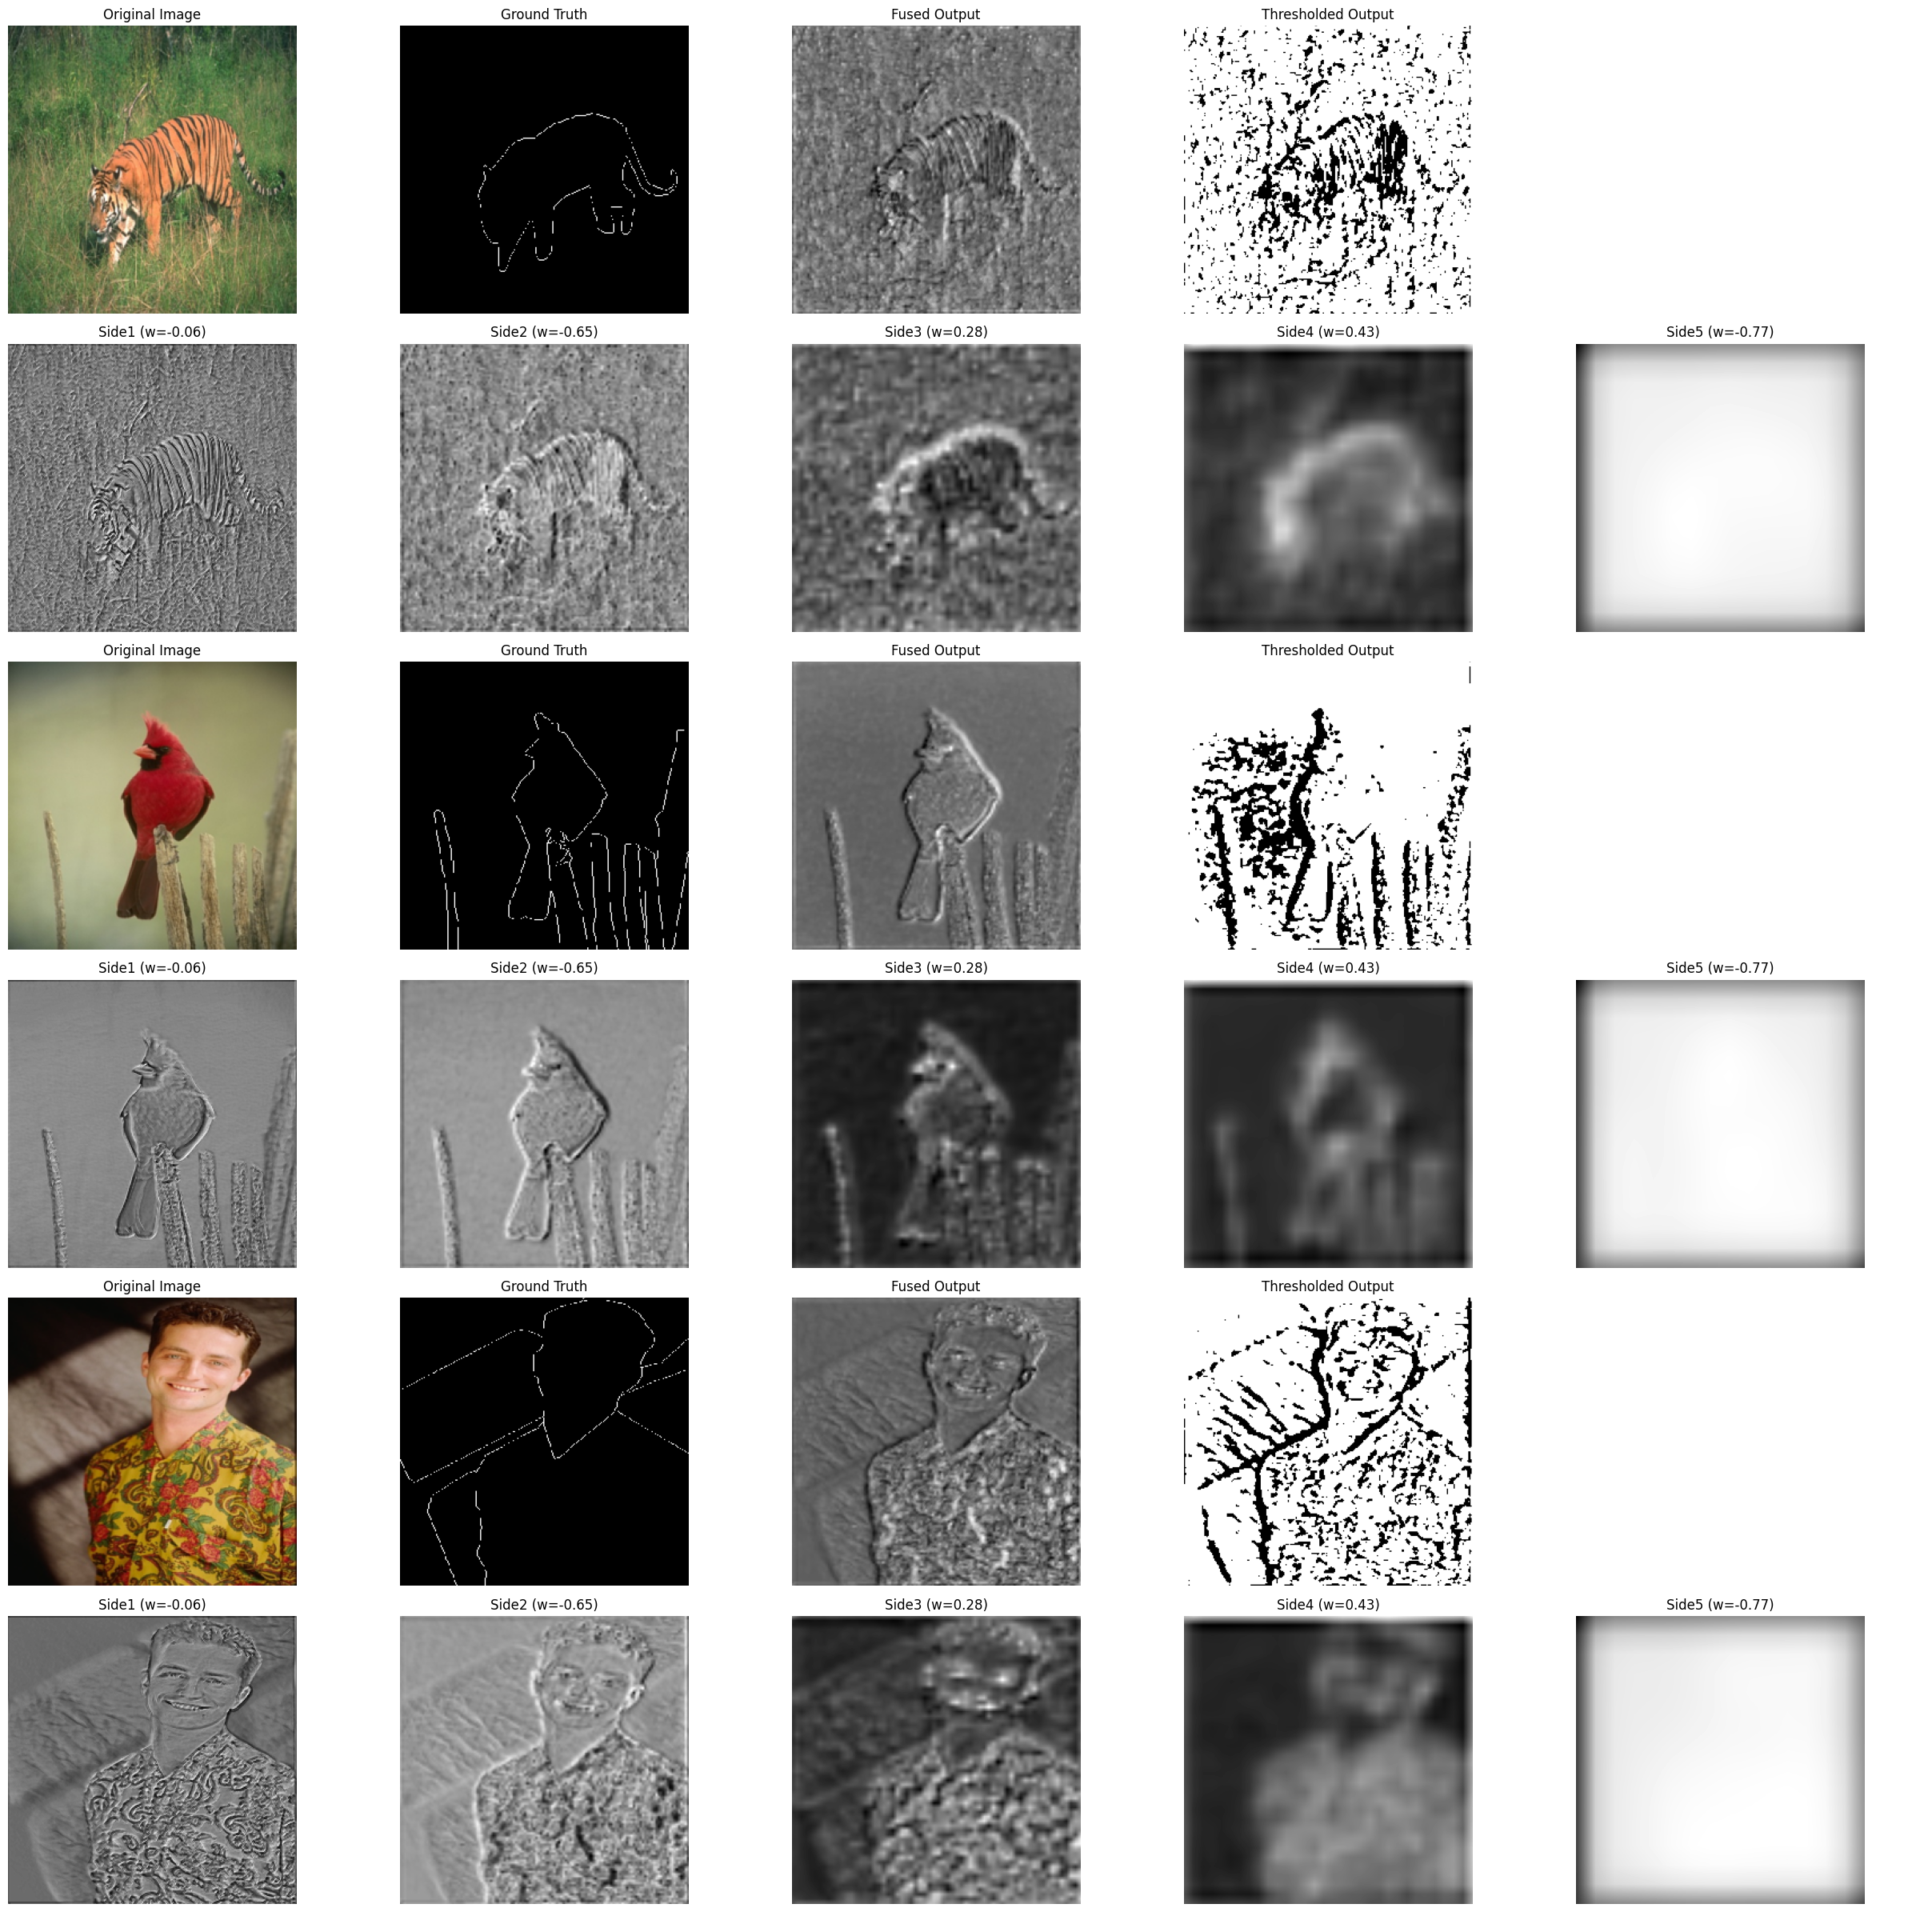

In [10]:
def main():
    # Ensure the dataset is downloaded and extracted
    download_and_extract_dataset()

    # Define transforms
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets and data loaders with correct paths
    train_dataset = BSDS500Dataset("BSR/BSDS500/data/images/train", 
                                  "BSR/BSDS500/data/groundTruth/train", 
                                  transform=train_transform)  # Use train_transform for training
    
    val_dataset = BSDS500Dataset("BSR/BSDS500/data/images/val", 
                                "BSR/BSDS500/data/groundTruth/val", 
                                transform=test_transform)
    
    test_dataset = BSDS500Dataset("BSR/BSDS500/data/images/test", 
                                 "BSR/BSDS500/data/groundTruth/test", 
                                 transform=test_transform)
    
    # Create data loaders
    BATCH_SIZE = 8
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)
    
    # Initialize model, loss, optimizer, and scheduler
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = HED().to(device)
    criterion = HEDLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)

    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    
    # Train model
    EPOCHS = 50
    print(f"Training HED model for {EPOCHS} epochs...")
    train_losses, val_losses = train(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler,
        epochs=EPOCHS, device=device, save_path="best_hed_model.pth"
    )

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('hed_loss_curve.png')
    plt.show()

    # Load best model for visualization
    checkpoint = torch.load("best_hed_model.pth")
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Visualize predictions 
    print("Visualizing predictions on test set...")
    visualize_predictions(model, test_loader, device)

    # Visualizing side outputs also
    print("Visualizing side outpusts...")
    visualize_sideoutput_predictions(model, test_loader, device)
if __name__ == "__main__":
    main()


# It can be concluded that the HED is doing a great job in making edge predictions, as good as canny edge detector(sometimes, even better). Also, results obtained for thresholded edges depend on the threshold value that we are using. 